In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Load consep

📥 Loading TNBC Nuclei Segmentation data...

✅ Found 50 image-mask pairs!

📐 Data structure:
  Image: 01_1.png
  Image shape: (512, 512, 3) - dtype: uint8
  Image value range: [70, 255]

  GT binary mask shape: (512, 512)
  GT binary values: [  0 255]

  Instance map shape: (512, 512)
  Number of instances: 69
  Instance IDs range: [0, 69]


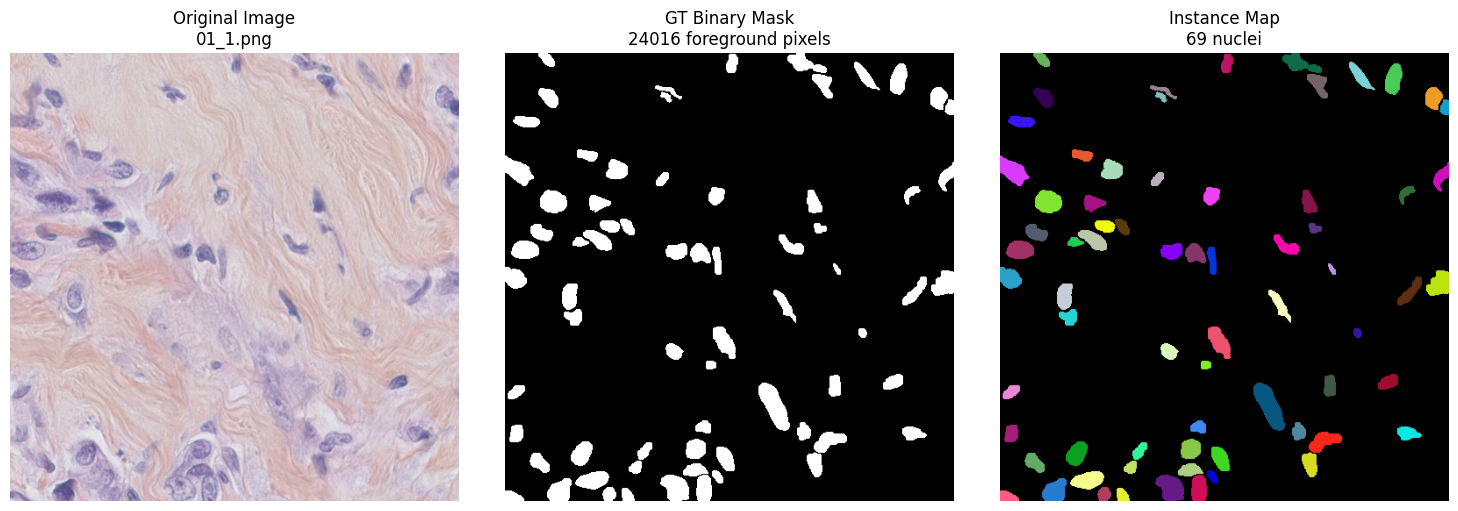


📂 Total dataset:
  Image-mask pairs: 50
  Slide folders: 11
  GT folders: 11


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2

# Dataset paths
tnbc_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/TNBC_NucleiSegmentation")

print("📥 Loading TNBC Nuclei Segmentation data...")

# Get all slide and GT directories
slide_dirs = sorted([d for d in tnbc_path.glob("Slide_*") if d.is_dir()])
gt_dirs = sorted([d for d in tnbc_path.glob("GT_*") if d.is_dir()])

# Collect all image-mask pairs
image_mask_pairs = []
for slide_dir, gt_dir in zip(slide_dirs, gt_dirs):
    slide_images = sorted(list(slide_dir.glob("*.png")) + 
                          list(slide_dir.glob("*.tif")) + 
                          list(slide_dir.glob("*.jpg")))
    gt_images = sorted(list(gt_dir.glob("*.png")) + 
                       list(gt_dir.glob("*.tif")))
    
    # Match by filename
    for img_path in slide_images:
        # Find corresponding GT with same base name
        img_base = img_path.stem  # e.g., "01_1"
        gt_path = gt_dir / f"{img_base}.png"
        
        if gt_path.exists():
            image_mask_pairs.append((img_path, gt_path))

print(f"\n✅ Found {len(image_mask_pairs)} image-mask pairs!")

# Function to convert binary mask to instance map
def binary_to_instance_map(binary_mask):
    """Convert binary mask (0/255) to instance segmentation map using connected components"""
    # Binarize
    binary = (binary_mask > 127).astype(np.uint8)
    
    # Connected components labeling
    num_labels, labels = cv2.connectedComponents(binary, connectivity=8)
    
    return labels.astype(np.int32)

# Load and visualize one sample
if image_mask_pairs:
    idx = 0  # First sample
    img_path, gt_path = image_mask_pairs[idx]
    
    # Load image (RGBA -> RGB)
    img = np.array(Image.open(img_path))
    if img.shape[2] == 4:  # RGBA
        img = img[:, :, :3]  # Take RGB only
    
    # Load GT binary mask
    gt_binary = np.array(Image.open(gt_path))
    
    # Convert to instance map
    gt_inst_map = binary_to_instance_map(gt_binary)
    
    print(f"\n📐 Data structure:")
    print(f"  Image: {img_path.name}")
    print(f"  Image shape: {img.shape} - dtype: {img.dtype}")
    print(f"  Image value range: [{img.min()}, {img.max()}]")
    
    print(f"\n  GT binary mask shape: {gt_binary.shape}")
    print(f"  GT binary values: {np.unique(gt_binary)}")
    
    print(f"\n  Instance map shape: {gt_inst_map.shape}")
    print(f"  Number of instances: {gt_inst_map.max()}")
    print(f"  Instance IDs range: [{gt_inst_map.min()}, {gt_inst_map.max()}]")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image\n{img_path.name}')
    axes[0].axis('off')
    
    axes[1].imshow(gt_binary, cmap='gray')
    axes[1].set_title(f'GT Binary Mask\n{np.sum(gt_binary > 127)} foreground pixels')
    axes[1].axis('off')
    
    # Colorize instances
    colored_inst = np.zeros((*gt_inst_map.shape, 3), dtype=np.uint8)
    np.random.seed(42)
    for inst_id in np.unique(gt_inst_map):
        if inst_id == 0:
            continue
        colored_inst[gt_inst_map == inst_id] = np.random.randint(0, 255, 3)
    
    axes[2].imshow(colored_inst)
    axes[2].set_title(f'Instance Map\n{gt_inst_map.max()} nuclei')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📂 Total dataset:")
    print(f"  Image-mask pairs: {len(image_mask_pairs)}")
    print(f"  Slide folders: {len(slide_dirs)}")
    print(f"  GT folders: {len(gt_dirs)}")

Building H&E Baseline encoder with DINOv2-large
✓ VitaminPBaselineHE initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]


2026-01-20 18:00:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 18:00:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 18:00:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 18:00:22 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 18:00:22 - WSIPredictor - INFO -   Overlap: 64
2026-01-20 18:00:22 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 18:00:22 - WSIPredictor - INFO -    ⚠ No MPP in metadata, using default: 0.2630 μm/px
2026-01-20 18:00:22 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 18:00:22 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 18:00:22 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 18:00:22 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 18:00:22 - WSIPredictor - INFO -    Min area filter: 3.0 μm² = 43 pixels²
2026-01-20 18:00:22 - WSIPredictor - INFO - 📁 Opening H&E WSI: temp_tnbc/09_3.png
2026-01-20 18:00:22 - WSIPredictor - INFO -    ✓ Si

Found 50 image-mask pairs
🔍 Processing: 09_3.png
  Image shape: (512, 512, 3)
  GT nuclei: 59

🔄 Running inference with WSIPredictor...
   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
2026-01-20 18:00:22 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 18:00:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:00:22 - WSIPredictor - INFO -    Found 23 edge cells to check for overlaps
2026-01-20 18:00:22 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 18:00:22 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 18:00:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 18:00:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:00:22 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 18:00:22 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 18:00:22 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:00:22 - WSIPredictor - INFO - ✅ Comple

✅ Detected 75 nuclei in 0.18s

📊 Computing metrics...

🔬 INSTANCE SEGMENTATION METRICS
  PQ (Panoptic Quality):     0.6108
  DQ (Detection Quality):    0.7910
  SQ (Segmentation Quality): 0.7721
  AJI (Agg. Jaccard Index):  0.5662


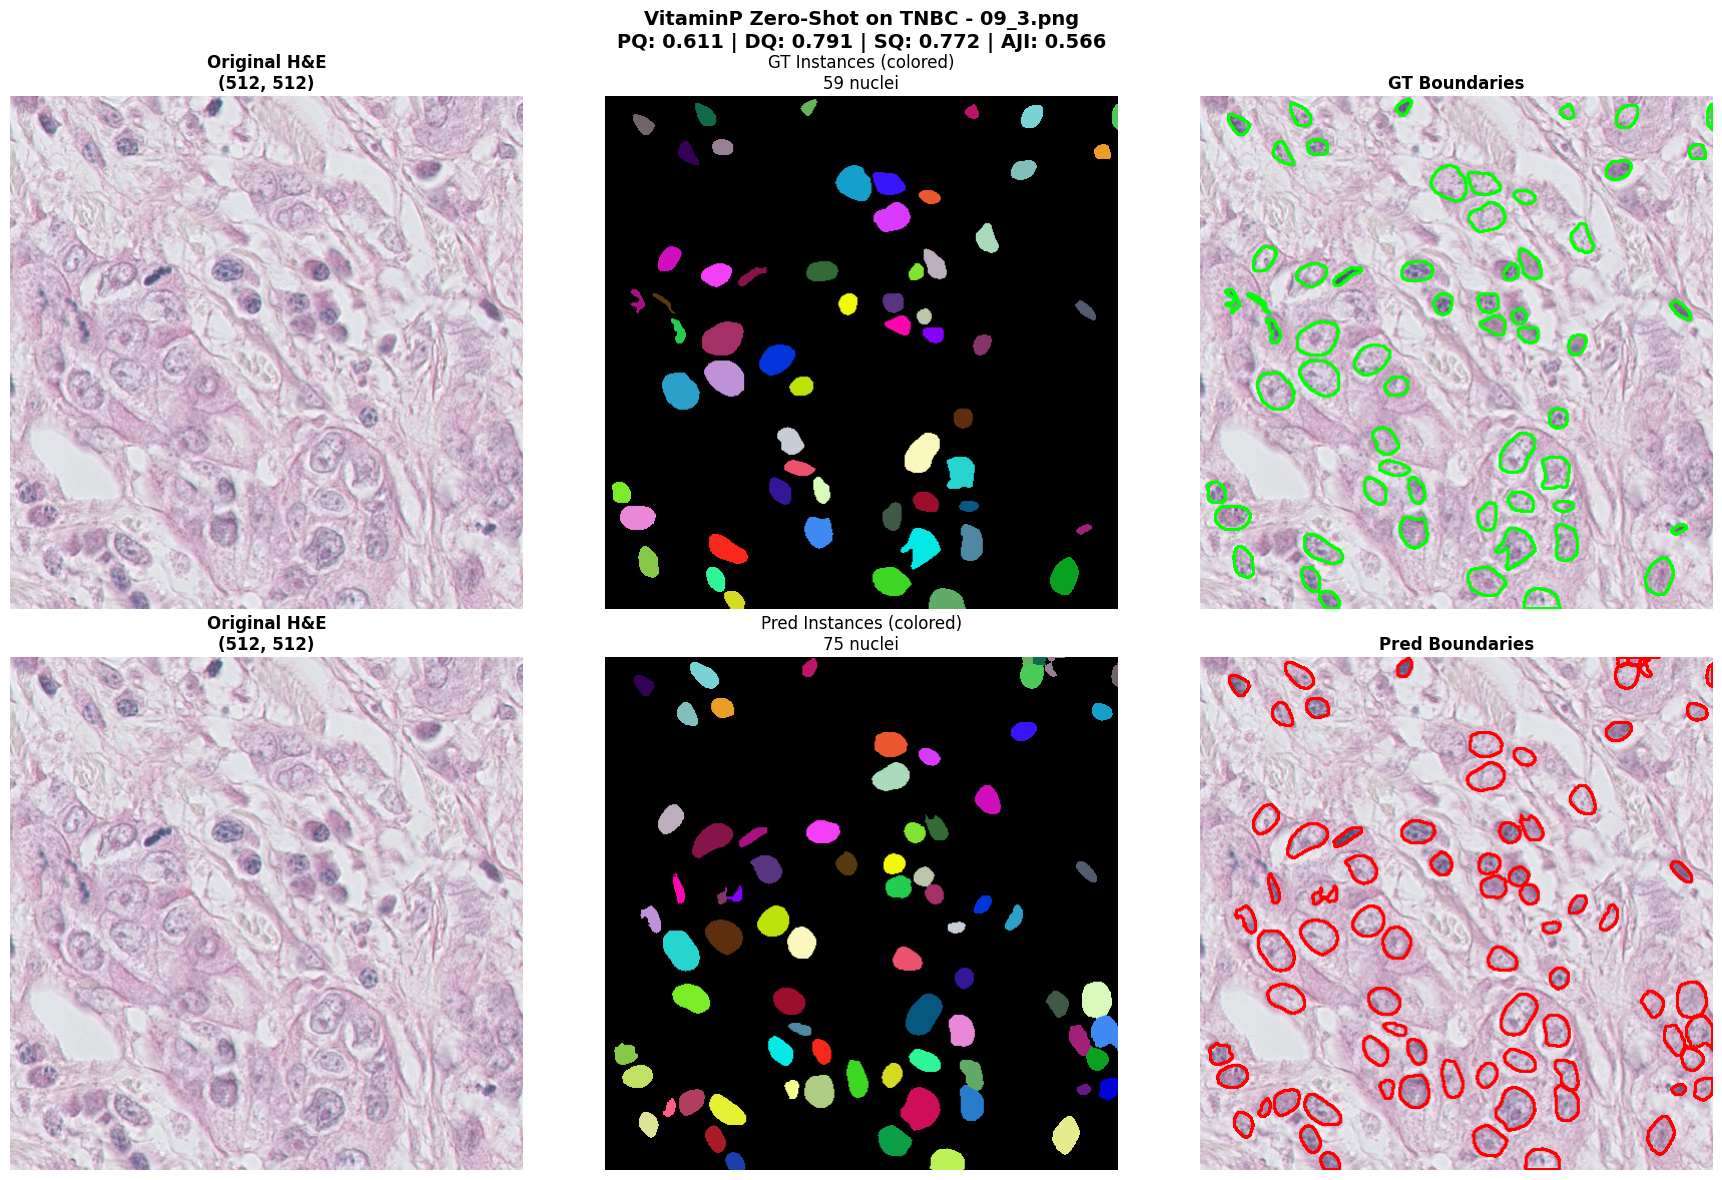


📊 Summary:
  GT: 59 nuclei
  Predicted: 75 nuclei
  Difference: 16 (27.1%)

  Metrics:
  - Panoptic Quality (PQ): 0.6108
  - Detection Quality (DQ): 0.7910
  - Segmentation Quality (SQ): 0.7721
  - Aggregated Jaccard Index (AJI): 0.5662


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
from vitaminp import VitaminPBaselineHE
from vitaminp.inference import WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index

# Function to convert binary mask to instance map
def binary_to_instance_map(binary_mask):
    """Convert binary mask (0/255) to instance segmentation map"""
    binary = (binary_mask > 127).astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(binary, connectivity=8)
    return labels.astype(np.int32)

# Setup model
device = 'cuda'
model = VitaminPBaselineHE(model_size='large', dropout_rate=0.3, freeze_backbone=False)
model.load_state_dict(torch.load("checkpoints/vitamin_p_baselinehe_large_fold3_best.pth", map_location=device))
model = model.to(device)
model.eval()

# Load TNBC data
tnbc_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/TNBC_NucleiSegmentation")
slide_dirs = sorted([d for d in tnbc_path.glob("Slide_*") if d.is_dir()])
gt_dirs = sorted([d for d in tnbc_path.glob("GT_*") if d.is_dir()])

# Collect all image-mask pairs
image_mask_pairs = []
for slide_dir, gt_dir in zip(slide_dirs, gt_dirs):
    slide_images = sorted(list(slide_dir.glob("*.png")))
    for img_path in slide_images:
        img_base = img_path.stem
        gt_path = gt_dir / f"{img_base}.png"
        if gt_path.exists():
            image_mask_pairs.append((img_path, gt_path))

print(f"Found {len(image_mask_pairs)} image-mask pairs")

# Load one random sample
if len(image_mask_pairs) > 0:
    idx = np.random.randint(0, len(image_mask_pairs))
    img_path, gt_path = image_mask_pairs[idx]
    filename = img_path.name
    
    # Load image (RGBA -> RGB)
    img = np.array(Image.open(img_path))
    if img.shape[2] == 4:
        img = img[:, :, :3]
    
    # Load GT and convert to instance map
    gt_binary = np.array(Image.open(gt_path))
    gt_mask = binary_to_instance_map(gt_binary)
    
    print(f"🔍 Processing: {filename}")
    print(f"  Image shape: {img.shape}")
    print(f"  GT nuclei: {gt_mask.max()}")
else:
    print("❌ No images loaded!")
    import sys
    sys.exit()

# Create temp directories
temp_dir = Path("temp_tnbc")
temp_output_dir = Path("temp_tnbc_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

temp_img_path = temp_dir / filename
Image.fromarray(img.astype(np.uint8)).save(temp_img_path)

# Create predictor
predictor = WSIPredictor(
    model=model,
    device=device,
    patch_size=512,
    overlap=64,
    target_mpp=0.263, 
    magnification=40
)

print("\n🔄 Running inference with WSIPredictor...")

# Run inference
results = predictor.predict(
    wsi_path=str(temp_img_path),
    output_dir=str(temp_output_dir),
    branch='he_nuclei',
    filter_tissue=False,
    clean_overlaps=True,
    save_geojson=False,
    save_json=False,
    save_csv=False,
    save_visualization=False,
    save_masks=False
)

print(f"✅ Detected {results['num_detections']} nuclei in {results['processing_time']:.2f}s")

# Extract instances dictionary
instances_dict = results['instances']

# Create instance map from the dictionary
h, w = img.shape[:2]
nuclei_inst = np.zeros((h, w), dtype=np.int32)

for inst_id, inst_info in instances_dict.items():
    if 'contour' in inst_info:
        contour = np.array(inst_info['contour'], dtype=np.int32)
        cv2.fillPoly(nuclei_inst, [contour], inst_id)
    elif 'coords' in inst_info:
        coords = np.array(inst_info['coords'], dtype=np.int32)
        cv2.fillPoly(nuclei_inst, [coords], inst_id)

num_nuclei = results['num_detections']
num_gt_nuclei = int(gt_mask.max())

# ========== COMPUTE METRICS ==========
print("\n📊 Computing metrics...")
try:
    pq, dq, sq = get_fast_pq(gt_mask, nuclei_inst)
    aji = aggregated_jaccard_index(gt_mask, nuclei_inst)
    
    print("\n" + "="*60)
    print("🔬 INSTANCE SEGMENTATION METRICS")
    print("="*60)
    print(f"  PQ (Panoptic Quality):     {pq:.4f}")
    print(f"  DQ (Detection Quality):    {dq:.4f}")
    print(f"  SQ (Segmentation Quality): {sq:.4f}")
    print(f"  AJI (Agg. Jaccard Index):  {aji:.4f}")
    print("="*60)
except Exception as e:
    print(f"⚠️ Error computing metrics: {str(e)}")
    pq, dq, sq, aji = 0, 0, 0, 0

# Visualization functions
def colorize_instances(inst_map):
    colored = np.zeros((*inst_map.shape, 3), dtype=np.uint8)
    unique_ids = np.unique(inst_map)
    np.random.seed(42)
    for inst_id in unique_ids:
        if inst_id == 0:
            continue
        colored[inst_map == inst_id] = np.random.randint(0, 255, 3)
    return colored

def draw_instance_boundaries(image, inst_map, color=(0, 255, 0), thickness=1):
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        output = image.copy()
    
    unique_ids = np.unique(inst_map)
    for inst_id in unique_ids:
        if inst_id == 0:
            continue
        mask = (inst_map == inst_id).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output, contours, -1, color, thickness)
    
    return output

# Visualize results
img_viz = img.astype(np.uint8)
gt_colored = colorize_instances(gt_mask)
pred_colored = colorize_instances(nuclei_inst)

gt_boundaries = draw_instance_boundaries(img_viz.copy(), gt_mask, color=(0, 255, 0), thickness=2)
pred_boundaries = draw_instance_boundaries(img_viz.copy(), nuclei_inst, color=(255, 0, 0), thickness=2)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Ground Truth
axes[0, 0].imshow(img_viz)
axes[0, 0].set_title(f'Original H&E\n{img.shape[:2]}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_colored)
axes[0, 1].set_title(f'GT Instances (colored)\n{num_gt_nuclei} nuclei', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(gt_boundaries)
axes[0, 2].set_title(f'GT Boundaries', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Predictions
axes[1, 0].imshow(img_viz)
axes[1, 0].set_title(f'Original H&E\n{img.shape[:2]}', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_colored)
axes[1, 1].set_title(f'Pred Instances (colored)\n{num_nuclei} nuclei', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_boundaries)
axes[1, 2].set_title(f'Pred Boundaries', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

# Add metrics as suptitle
plt.suptitle(f'VitaminP Zero-Shot on TNBC - {filename}\n'
             f'PQ: {pq:.3f} | DQ: {dq:.3f} | SQ: {sq:.3f} | AJI: {aji:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"  GT: {num_gt_nuclei} nuclei")
print(f"  Predicted: {num_nuclei} nuclei")
print(f"  Difference: {num_nuclei - num_gt_nuclei} ({((num_nuclei - num_gt_nuclei) / num_gt_nuclei * 100):.1f}%)")
print(f"\n  Metrics:")
print(f"  - Panoptic Quality (PQ): {pq:.4f}")
print(f"  - Detection Quality (DQ): {dq:.4f}")
print(f"  - Segmentation Quality (SQ): {sq:.4f}")
print(f"  - Aggregated Jaccard Index (AJI): {aji:.4f}")

# Cleanup temp files
import shutil
shutil.rmtree(temp_dir)
shutil.rmtree(temp_output_dir)

## Run vitaminp Flex

In [14]:
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import cv2
from vitaminp import VitaminPBaselineHE
from vitaminp.inference import WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index
from tqdm import tqdm
import shutil

# Function to convert binary mask to instance map
def binary_to_instance_map(binary_mask):
    """Convert binary mask (0/255) to instance segmentation map"""
    binary = (binary_mask > 127).astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(binary, connectivity=8)
    return labels.astype(np.int32)

# Setup model
device = 'cuda'
print("📦 Loading model...")
model = VitaminPBaselineHE(model_size='large', dropout_rate=0.3, freeze_backbone=False)
model.load_state_dict(torch.load("checkpoints/vitamin_p_baselinehe_large_fold3_best.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded")

# Load TNBC data
tnbc_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/TNBC_NucleiSegmentation")

# Get all slide and GT directories
slide_dirs = sorted([d for d in tnbc_path.glob("Slide_*") if d.is_dir()])
gt_dirs = sorted([d for d in tnbc_path.glob("GT_*") if d.is_dir()])

# Collect all image-mask pairs
image_mask_pairs = []
for slide_dir, gt_dir in zip(slide_dirs, gt_dirs):
    slide_images = sorted(list(slide_dir.glob("*.png")))
    for img_path in slide_images:
        img_base = img_path.stem  # e.g., "01_1"
        gt_path = gt_dir / f"{img_base}.png"
        if gt_path.exists():
            image_mask_pairs.append((img_path, gt_path))

print(f"\n🔍 Found {len(image_mask_pairs)} image-mask pairs in TNBC dataset")

if len(image_mask_pairs) == 0:
    print("❌ No image-mask pairs found! Check dataset structure.")
    import sys
    sys.exit()

# Create temp directories
temp_dir = Path("temp_tnbc")
temp_output_dir = Path("temp_tnbc_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

# Initialize metric storage
tnbc_metrics = {
    'pq': [],
    'dq': [],
    'sq': [],
    'aji': [],
    'gt_count': [],
    'pred_count': []
}

# Store per-sample results for detailed analysis
sample_results = []

print(f"\n🔄 Evaluating on TNBC dataset ({len(image_mask_pairs)} samples)...")
print("="*80)

skipped_samples = 0

for idx in tqdm(range(len(image_mask_pairs)), desc="Processing samples"):
    try:
        # Load image and label
        img_path, gt_path = image_mask_pairs[idx]
        filename = img_path.name
        
        # Load image (RGBA -> RGB if needed)
        img = np.array(Image.open(img_path))
        if len(img.shape) == 3 and img.shape[2] == 4:  # RGBA
            img = img[:, :, :3]
        
        # Load GT binary mask and convert to instance map
        gt_binary = np.array(Image.open(gt_path))
        gt_inst_map = binary_to_instance_map(gt_binary)
        
        # Save temp image for predictor
        temp_img_path = temp_dir / filename
        Image.fromarray(img.astype(np.uint8)).save(temp_img_path)
        
        # Create predictor
        predictor = WSIPredictor(
            model=model,
            device=device,
            patch_size=512,
            overlap=64,
            target_mpp=0.263, 
            magnification=40
        )
        
        # Run inference
        results = predictor.predict(
            wsi_path=str(temp_img_path),
            output_dir=str(temp_output_dir),
            branch='he_nuclei',
            filter_tissue=False,
            clean_overlaps=True,
            save_geojson=False,
            save_json=False,
            save_csv=False,
            save_visualization=False,
            save_masks=False
        )
        
        # Extract instances dictionary
        instances_dict = results['instances']
        
        # Create instance map from the dictionary
        h, w = img.shape[:2]
        nuclei_inst = np.zeros((h, w), dtype=np.int32)
        
        for inst_id, inst_info in instances_dict.items():
            if 'contour' in inst_info:
                contour = np.array(inst_info['contour'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst, [contour], inst_id)
            elif 'coords' in inst_info:
                coords = np.array(inst_info['coords'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst, [coords], inst_id)
        
        # Compute metrics
        pq, dq, sq = get_fast_pq(gt_inst_map, nuclei_inst)
        aji = aggregated_jaccard_index(gt_inst_map, nuclei_inst)
        
        num_gt = int(gt_inst_map.max())
        num_pred = results['num_detections']
        
        # Store metrics
        tnbc_metrics['pq'].append(pq)
        tnbc_metrics['dq'].append(dq)
        tnbc_metrics['sq'].append(sq)
        tnbc_metrics['aji'].append(aji)
        tnbc_metrics['gt_count'].append(num_gt)
        tnbc_metrics['pred_count'].append(num_pred)
        
        # Store detailed sample results
        sample_results.append({
            'filename': filename,
            'pq': pq,
            'dq': dq,
            'sq': sq,
            'aji': aji,
            'gt_count': num_gt,
            'pred_count': num_pred
        })
        
        # Cleanup sample temp files
        temp_img_path.unlink()
        
    except Exception as e:
        print(f"\n⚠️ Skipping sample {idx} ({image_mask_pairs[idx][0].name}) due to error: {str(e)[:100]}")
        import traceback
        traceback.print_exc()
        skipped_samples += 1
        continue

# Cleanup temp directories
shutil.rmtree(temp_dir, ignore_errors=True)
shutil.rmtree(temp_output_dir, ignore_errors=True)

# ========== OVERALL RESULTS ==========
print("\n" + "="*80)
print("📊 TNBC DATASET RESULTS - ZERO-SHOT EVALUATION")
print("="*80)

print(f"\nTotal samples processed: {len(tnbc_metrics['pq'])}/{len(image_mask_pairs)}")
if skipped_samples > 0:
    print(f"⚠️ Skipped samples: {skipped_samples}")

if len(tnbc_metrics['pq']) > 0:
    print("\n🔬 NUCLEI INSTANCE METRICS (all samples):")
    print(f"  PQ (Panoptic Quality):     {np.mean(tnbc_metrics['pq']):.4f} ± {np.std(tnbc_metrics['pq']):.4f}")
    print(f"  DQ (Detection Quality):    {np.mean(tnbc_metrics['dq']):.4f} ± {np.std(tnbc_metrics['dq']):.4f}")
    print(f"  SQ (Segmentation Quality): {np.mean(tnbc_metrics['sq']):.4f} ± {np.std(tnbc_metrics['sq']):.4f}")
    print(f"  AJI (Agg. Jaccard Index):  {np.mean(tnbc_metrics['aji']):.4f} ± {np.std(tnbc_metrics['aji']):.4f}")

    print("\n📈 DETECTION STATISTICS:")
    total_gt = sum(tnbc_metrics['gt_count'])
    total_pred = sum(tnbc_metrics['pred_count'])
    print(f"  Total GT nuclei:       {total_gt}")
    print(f"  Total Pred nuclei:     {total_pred}")
    print(f"  Average GT per image:  {np.mean(tnbc_metrics['gt_count']):.1f} ± {np.std(tnbc_metrics['gt_count']):.1f}")
    print(f"  Average Pred per image: {np.mean(tnbc_metrics['pred_count']):.1f} ± {np.std(tnbc_metrics['pred_count']):.1f}")
    if total_gt > 0:
        print(f"  Detection ratio:       {total_pred/total_gt:.3f}")
    else:
        print(f"  Detection ratio:       N/A (no GT nuclei)")

    # ========== TOP/BOTTOM PERFORMERS ==========
    print("\n" + "="*80)
    print("🏆 TOP 5 SAMPLES (by PQ)")
    print("="*80)

    sorted_by_pq = sorted(sample_results, key=lambda x: x['pq'], reverse=True)
    print(f"{'Rank':<6} {'Filename':<40} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
    print("-" * 80)
    for i, result in enumerate(sorted_by_pq[:5], 1):
        print(f"{i:<6} {result['filename']:<40} {result['pq']:>8.4f} {result['dq']:>8.4f} "
              f"{result['sq']:>8.4f} {result['aji']:>8.4f}")

    print("\n" + "="*80)
    print("⚠️  BOTTOM 5 SAMPLES (by PQ)")
    print("="*80)
    print(f"{'Rank':<6} {'Filename':<40} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
    print("-" * 80)
    for i, result in enumerate(sorted_by_pq[-5:], 1):
        print(f"{i:<6} {result['filename']:<40} {result['pq']:>8.4f} {result['dq']:>8.4f} "
              f"{result['sq']:>8.4f} {result['aji']:>8.4f}")

    # ========== PER-SAMPLE DETAILED RESULTS ==========
    print("\n" + "="*80)
    print("📋 DETAILED PER-SAMPLE RESULTS")
    print("="*80)
    print(f"{'Filename':<40} {'GT':>6} {'Pred':>6} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
    print("-" * 80)
    for result in sorted(sample_results, key=lambda x: x['filename']):
        print(f"{result['filename']:<40} {result['gt_count']:>6} {result['pred_count']:>6} "
              f"{result['pq']:>8.4f} {result['dq']:>8.4f} {result['sq']:>8.4f} {result['aji']:>8.4f}")
else:
    print("\n❌ No samples were successfully processed!")

print("\n" + "="*80)
print("✅ TNBC evaluation complete!")
print("="*80)

📦 Loading model...
Building H&E Baseline encoder with DINOv2-large
✓ VitaminPBaselineHE initialized with large backbone
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔍 Found 50 image-mask pairs in TNBC dataset

🔄 Evaluating on TNBC dataset (50 samples)...


Processing samples:   0%|          | 0/50 [00:00<?, ?it/s]2026-01-20 18:03:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 18:03:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 18:03:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 18:03:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 18:03:35 - WSIPredictor - INFO -   Overlap: 64
2026-01-20 18:03:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 18:03:35 - WSIPredictor - INFO -    ⚠ No MPP in metadata, using default: 0.2630 μm/px
2026-01-20 18:03:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 18:03:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 18:03:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 18:03:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 18:03:35 - WSIPredictor - INFO -    Min area filter: 3.0 μm² = 43 pixels²
2026-01-20 18:03:35 - WSIPredictor - INFO - 📁 Opening H&E WSI: temp_tnbc/01

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]
2026-01-20 18:03:35 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 18:03:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:35 - WSIPredictor - INFO -    Found 31 edge cells to check for overlaps
2026-01-20 18:03:35 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 18:03:35 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 18:03:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 18:03:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:35 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 18:03:35 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 18:03:35 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:35 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
2026-01-20 18:03:35 - WSIPredictor - INFO -    ✓ Extracted 165 instances from tiles (before cleaning)
2026-01-20 18:03:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:35 - WSIPredictor - INFO -    Found 49 edge cells to check for overlaps
2026-01-20 18:03:35 - WSIPredictor - INFO - Starting overlap cleaning with 165 detections
2026-01-20 18:03:35 - WSIPredictor - INFO - Split detections: 0 mid, 165 edge
2026-01-20 18:03:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 165/165 detections
2026-01-20 18:03:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:35 - WSIPredictor - INFO - Cleaning complete: 165 -> 165 (0 removed)
2026-01-20 18:03:35 - WSIPredictor - INFO -    ✓ After cleaning: 165 instances
2026-01-20 18:03:35 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:35 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]
2026-01-20 18:03:36 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 18:03:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 18:03:36 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 18:03:36 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 18:03:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 18:03:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:36 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)
2026-01-20 18:03:36 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 18:03:36 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:36 - WSIPredictor - INFO - ✅ Complete! 4 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
2026-01-20 18:03:36 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 18:03:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:36 - WSIPredictor - INFO -    Found 52 edge cells to check for overlaps
2026-01-20 18:03:36 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 18:03:36 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 18:03:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 18:03:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:36 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 18:03:36 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 18:03:36 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:36 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 18:03:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:37 - WSIPredictor - INFO -    Found 1 edge cells to check for overlaps
2026-01-20 18:03:37 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 18:03:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:37 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 18:03:37 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:37 - WSIPredictor - INFO - ✅ Complete! 9 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 18:03:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:37 - WSIPredictor - INFO -    Found 7 edge cells to check for overlaps
2026-01-20 18:03:37 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 18:03:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:37 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 18:03:37 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:37 - WSIPredictor - INFO - ✅ Comple

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 18:03:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:37 - WSIPredictor - INFO -    Found 26 edge cells to check for overlaps
2026-01-20 18:03:37 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 18:03:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:37 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 18:03:37 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:37 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 18:03:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:37 - WSIPredictor - INFO -    Found 2 edge cells to check for overlaps
2026-01-20 18:03:37 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 18:03:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 18:03:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:37 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 18:03:37 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 18:03:37 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:37 - WSIPredictor - INFO - ✅ Complete! 9 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
2026-01-20 18:03:38 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 18:03:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:38 - WSIPredictor - INFO -    Found 24 edge cells to check for overlaps
2026-01-20 18:03:38 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 18:03:38 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 18:03:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 18:03:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:38 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 18:03:38 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 18:03:38 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:38 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
2026-01-20 18:03:38 - WSIPredictor - INFO -    ✓ Extracted 131 instances from tiles (before cleaning)
2026-01-20 18:03:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:38 - WSIPredictor - INFO -    Found 45 edge cells to check for overlaps
2026-01-20 18:03:38 - WSIPredictor - INFO - Starting overlap cleaning with 131 detections
2026-01-20 18:03:38 - WSIPredictor - INFO - Split detections: 0 mid, 131 edge
2026-01-20 18:03:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 131/131 detections
2026-01-20 18:03:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:38 - WSIPredictor - INFO - Cleaning complete: 131 -> 131 (0 removed)
2026-01-20 18:03:38 - WSIPredictor - INFO -    ✓ After cleaning: 131 instances
2026-01-20 18:03:38 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:38 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]
2026-01-20 18:03:39 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 18:03:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:39 - WSIPredictor - INFO -    Found 16 edge cells to check for overlaps
2026-01-20 18:03:39 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 18:03:39 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 18:03:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 18:03:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:39 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 18:03:39 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 18:03:39 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:39 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2026-01-20 18:03:39 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 18:03:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:39 - WSIPredictor - INFO -    Found 27 edge cells to check for overlaps
2026-01-20 18:03:39 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 18:03:39 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 18:03:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 18:03:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:39 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 18:03:39 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 18:03:39 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:39 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]
2026-01-20 18:03:39 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 18:03:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:39 - WSIPredictor - INFO -    Found 6 edge cells to check for overlaps
2026-01-20 18:03:39 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 18:03:39 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 18:03:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 18:03:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:39 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 18:03:39 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 18:03:39 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:39 - WSIPredictor - INFO - ✅ Comple

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]
2026-01-20 18:03:40 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 18:03:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:40 - WSIPredictor - INFO -    Found 7 edge cells to check for overlaps
2026-01-20 18:03:40 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 18:03:40 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 18:03:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 18:03:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:40 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 18:03:40 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 18:03:40 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:40 - WSIPredictor - INFO - ✅ Comple

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]
2026-01-20 18:03:40 - WSIPredictor - INFO -    ✓ Extracted 59 instances from tiles (before cleaning)
2026-01-20 18:03:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:40 - WSIPredictor - INFO -    Found 15 edge cells to check for overlaps
2026-01-20 18:03:40 - WSIPredictor - INFO - Starting overlap cleaning with 59 detections
2026-01-20 18:03:40 - WSIPredictor - INFO - Split detections: 0 mid, 59 edge
2026-01-20 18:03:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 59/59 detections
2026-01-20 18:03:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:40 - WSIPredictor - INFO - Cleaning complete: 59 -> 59 (0 removed)
2026-01-20 18:03:40 - WSIPredictor - INFO -    ✓ After cleaning: 59 instances
2026-01-20 18:03:40 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:40 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
2026-01-20 18:03:40 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 18:03:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:40 - WSIPredictor - INFO -    Found 62 edge cells to check for overlaps
2026-01-20 18:03:40 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 18:03:40 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge
2026-01-20 18:03:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 18:03:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:40 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 18:03:40 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 18:03:40 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:40 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]
2026-01-20 18:03:41 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 18:03:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:41 - WSIPredictor - INFO -    Found 1 edge cells to check for overlaps
2026-01-20 18:03:41 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 18:03:41 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 18:03:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 18:03:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:41 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 18:03:41 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 18:03:41 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:41 - WSIPredictor - INFO - ✅ Complete! 2 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]
2026-01-20 18:03:41 - WSIPredictor - INFO -    ✓ Extracted 3 instances from tiles (before cleaning)
2026-01-20 18:03:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:41 - WSIPredictor - INFO -    Found 1 edge cells to check for overlaps
2026-01-20 18:03:41 - WSIPredictor - INFO - Starting overlap cleaning with 3 detections
2026-01-20 18:03:41 - WSIPredictor - INFO - Split detections: 0 mid, 3 edge
2026-01-20 18:03:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 3/3 detections
2026-01-20 18:03:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:41 - WSIPredictor - INFO - Cleaning complete: 3 -> 3 (0 removed)
2026-01-20 18:03:41 - WSIPredictor - INFO -    ✓ After cleaning: 3 instances
2026-01-20 18:03:41 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:41 - WSIPredictor - INFO - ✅ Complete! 3 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
2026-01-20 18:03:41 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 18:03:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:41 - WSIPredictor - INFO -    Found 34 edge cells to check for overlaps
2026-01-20 18:03:41 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 18:03:41 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 18:03:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 18:03:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:41 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 18:03:41 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 18:03:41 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:41 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]
2026-01-20 18:03:42 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 18:03:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:42 - WSIPredictor - INFO -    Found 2 edge cells to check for overlaps
2026-01-20 18:03:42 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 18:03:42 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 18:03:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 18:03:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:42 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)
2026-01-20 18:03:42 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 18:03:42 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:42 - WSIPredictor - INFO - ✅ Complete! 4 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]
2026-01-20 18:03:42 - WSIPredictor - INFO -    ✓ Extracted 48 instances from tiles (before cleaning)
2026-01-20 18:03:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:42 - WSIPredictor - INFO -    Found 13 edge cells to check for overlaps
2026-01-20 18:03:42 - WSIPredictor - INFO - Starting overlap cleaning with 48 detections
2026-01-20 18:03:42 - WSIPredictor - INFO - Split detections: 0 mid, 48 edge
2026-01-20 18:03:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 48/48 detections
2026-01-20 18:03:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:42 - WSIPredictor - INFO - Cleaning complete: 48 -> 48 (0 removed)
2026-01-20 18:03:42 - WSIPredictor - INFO -    ✓ After cleaning: 48 instances
2026-01-20 18:03:42 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:42 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]
2026-01-20 18:03:43 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 18:03:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:43 - WSIPredictor - INFO -    Found 11 edge cells to check for overlaps
2026-01-20 18:03:43 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 18:03:43 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 18:03:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 18:03:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:43 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 18:03:43 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 18:03:43 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:43 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
2026-01-20 18:03:43 - WSIPredictor - INFO -    ✓ Extracted 167 instances from tiles (before cleaning)
2026-01-20 18:03:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:43 - WSIPredictor - INFO -    Found 61 edge cells to check for overlaps
2026-01-20 18:03:43 - WSIPredictor - INFO - Starting overlap cleaning with 167 detections
2026-01-20 18:03:43 - WSIPredictor - INFO - Split detections: 0 mid, 167 edge
2026-01-20 18:03:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 167/167 detections
2026-01-20 18:03:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:43 - WSIPredictor - INFO - Cleaning complete: 167 -> 167 (0 removed)
2026-01-20 18:03:43 - WSIPredictor - INFO -    ✓ After cleaning: 167 instances
2026-01-20 18:03:43 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:43 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
2026-01-20 18:03:44 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 18:03:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:44 - WSIPredictor - INFO -    Found 43 edge cells to check for overlaps
2026-01-20 18:03:44 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 18:03:44 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge
2026-01-20 18:03:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 18:03:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:44 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 18:03:44 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 18:03:44 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:44 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
2026-01-20 18:03:44 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 18:03:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:44 - WSIPredictor - INFO -    Found 34 edge cells to check for overlaps
2026-01-20 18:03:44 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 18:03:44 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 18:03:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 18:03:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:44 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 18:03:44 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 18:03:44 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:44 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
2026-01-20 18:03:45 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 18:03:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:45 - WSIPredictor - INFO -    Found 43 edge cells to check for overlaps
2026-01-20 18:03:45 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 18:03:45 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 18:03:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 18:03:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:45 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 18:03:45 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 18:03:45 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:45 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]
2026-01-20 18:03:45 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 18:03:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:45 - WSIPredictor - INFO -    Found 24 edge cells to check for overlaps
2026-01-20 18:03:45 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 18:03:45 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 18:03:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 18:03:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:45 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 18:03:45 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 18:03:45 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:45 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]
2026-01-20 18:03:45 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 18:03:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:45 - WSIPredictor - INFO -    Found 34 edge cells to check for overlaps
2026-01-20 18:03:45 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 18:03:45 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 18:03:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 18:03:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:45 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 18:03:45 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 18:03:45 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:45 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]
2026-01-20 18:03:46 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 18:03:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:46 - WSIPredictor - INFO -    Found 41 edge cells to check for overlaps
2026-01-20 18:03:46 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 18:03:46 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 18:03:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 18:03:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:46 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 18:03:46 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 18:03:46 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:46 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]
2026-01-20 18:03:46 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 18:03:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:46 - WSIPredictor - INFO -    Found 12 edge cells to check for overlaps
2026-01-20 18:03:46 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 18:03:46 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 18:03:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 18:03:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:46 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 18:03:46 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 18:03:46 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:46 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
2026-01-20 18:03:47 - WSIPredictor - INFO -    ✓ Extracted 160 instances from tiles (before cleaning)
2026-01-20 18:03:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:47 - WSIPredictor - INFO -    Found 58 edge cells to check for overlaps
2026-01-20 18:03:47 - WSIPredictor - INFO - Starting overlap cleaning with 160 detections
2026-01-20 18:03:47 - WSIPredictor - INFO - Split detections: 0 mid, 160 edge
2026-01-20 18:03:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 160/160 detections
2026-01-20 18:03:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:47 - WSIPredictor - INFO - Cleaning complete: 160 -> 160 (0 removed)
2026-01-20 18:03:47 - WSIPredictor - INFO -    ✓ After cleaning: 160 instances
2026-01-20 18:03:47 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:47 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
2026-01-20 18:03:47 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 18:03:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:47 - WSIPredictor - INFO -    Found 28 edge cells to check for overlaps
2026-01-20 18:03:47 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 18:03:47 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 18:03:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 18:03:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:47 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 18:03:47 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 18:03:47 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:47 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
2026-01-20 18:03:48 - WSIPredictor - INFO -    ✓ Extracted 289 instances from tiles (before cleaning)
2026-01-20 18:03:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:48 - WSIPredictor - INFO -    Found 92 edge cells to check for overlaps
2026-01-20 18:03:48 - WSIPredictor - INFO - Starting overlap cleaning with 289 detections
2026-01-20 18:03:48 - WSIPredictor - INFO - Split detections: 0 mid, 289 edge
2026-01-20 18:03:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 289/289 detections
2026-01-20 18:03:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:48 - WSIPredictor - INFO - Cleaning complete: 289 -> 289 (0 removed)
2026-01-20 18:03:48 - WSIPredictor - INFO -    ✓ After cleaning: 289 instances
2026-01-20 18:03:48 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:48 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
2026-01-20 18:03:49 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 18:03:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:49 - WSIPredictor - INFO -    Found 41 edge cells to check for overlaps
2026-01-20 18:03:49 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 18:03:49 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 18:03:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 18:03:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:49 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 18:03:49 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 18:03:49 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:49 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
2026-01-20 18:03:49 - WSIPredictor - INFO -    ✓ Extracted 137 instances from tiles (before cleaning)
2026-01-20 18:03:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:49 - WSIPredictor - INFO -    Found 47 edge cells to check for overlaps
2026-01-20 18:03:49 - WSIPredictor - INFO - Starting overlap cleaning with 137 detections
2026-01-20 18:03:49 - WSIPredictor - INFO - Split detections: 0 mid, 137 edge
2026-01-20 18:03:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 137/137 detections
2026-01-20 18:03:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:49 - WSIPredictor - INFO - Cleaning complete: 137 -> 137 (0 removed)
2026-01-20 18:03:49 - WSIPredictor - INFO -    ✓ After cleaning: 137 instances
2026-01-20 18:03:49 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:49 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
2026-01-20 18:03:50 - WSIPredictor - INFO -    ✓ Extracted 191 instances from tiles (before cleaning)
2026-01-20 18:03:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:50 - WSIPredictor - INFO -    Found 67 edge cells to check for overlaps
2026-01-20 18:03:50 - WSIPredictor - INFO - Starting overlap cleaning with 191 detections
2026-01-20 18:03:50 - WSIPredictor - INFO - Split detections: 0 mid, 191 edge
2026-01-20 18:03:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 191/191 detections
2026-01-20 18:03:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:50 - WSIPredictor - INFO - Cleaning complete: 191 -> 191 (0 removed)
2026-01-20 18:03:50 - WSIPredictor - INFO -    ✓ After cleaning: 191 instances
2026-01-20 18:03:50 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:50 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
2026-01-20 18:03:50 - WSIPredictor - INFO -    ✓ Extracted 124 instances from tiles (before cleaning)
2026-01-20 18:03:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:50 - WSIPredictor - INFO -    Found 45 edge cells to check for overlaps
2026-01-20 18:03:50 - WSIPredictor - INFO - Starting overlap cleaning with 124 detections
2026-01-20 18:03:50 - WSIPredictor - INFO - Split detections: 0 mid, 124 edge
2026-01-20 18:03:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 124/124 detections
2026-01-20 18:03:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:50 - WSIPredictor - INFO - Cleaning complete: 124 -> 124 (0 removed)
2026-01-20 18:03:50 - WSIPredictor - INFO -    ✓ After cleaning: 124 instances
2026-01-20 18:03:50 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:50 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
2026-01-20 18:03:51 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 18:03:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:51 - WSIPredictor - INFO -    Found 20 edge cells to check for overlaps
2026-01-20 18:03:51 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 18:03:51 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 18:03:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 18:03:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:51 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 18:03:51 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 18:03:51 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:51 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]
2026-01-20 18:03:51 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 18:03:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:51 - WSIPredictor - INFO -    Found 20 edge cells to check for overlaps
2026-01-20 18:03:51 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 18:03:51 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 18:03:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 18:03:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:51 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 18:03:51 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 18:03:51 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:51 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
2026-01-20 18:03:51 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 18:03:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:51 - WSIPredictor - INFO -    Found 23 edge cells to check for overlaps
2026-01-20 18:03:51 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 18:03:51 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 18:03:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 18:03:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:51 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 18:03:51 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 18:03:51 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:51 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
2026-01-20 18:03:52 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 18:03:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:52 - WSIPredictor - INFO -    Found 14 edge cells to check for overlaps
2026-01-20 18:03:52 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 18:03:52 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 18:03:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 18:03:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:52 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 18:03:52 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 18:03:52 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:52 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]
2026-01-20 18:03:52 - WSIPredictor - INFO -    ✓ Extracted 55 instances from tiles (before cleaning)
2026-01-20 18:03:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:52 - WSIPredictor - INFO -    Found 25 edge cells to check for overlaps
2026-01-20 18:03:52 - WSIPredictor - INFO - Starting overlap cleaning with 55 detections
2026-01-20 18:03:52 - WSIPredictor - INFO - Split detections: 0 mid, 55 edge
2026-01-20 18:03:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 55/55 detections
2026-01-20 18:03:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:52 - WSIPredictor - INFO - Cleaning complete: 55 -> 55 (0 removed)
2026-01-20 18:03:52 - WSIPredictor - INFO -    ✓ After cleaning: 55 instances
2026-01-20 18:03:52 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:52 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]
2026-01-20 18:03:52 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 18:03:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:52 - WSIPredictor - INFO -    Found 2 edge cells to check for overlaps
2026-01-20 18:03:52 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 18:03:52 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 18:03:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 18:03:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:52 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 18:03:52 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 18:03:52 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:52 - WSIPredictor - INFO - ✅ Complete! 2 de

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
2026-01-20 18:03:53 - WSIPredictor - INFO -    ✓ Extracted 197 instances from tiles (before cleaning)
2026-01-20 18:03:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:53 - WSIPredictor - INFO -    Found 67 edge cells to check for overlaps
2026-01-20 18:03:53 - WSIPredictor - INFO - Starting overlap cleaning with 197 detections
2026-01-20 18:03:53 - WSIPredictor - INFO - Split detections: 0 mid, 197 edge
2026-01-20 18:03:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 197/197 detections
2026-01-20 18:03:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:53 - WSIPredictor - INFO - Cleaning complete: 197 -> 197 (0 removed)
2026-01-20 18:03:53 - WSIPredictor - INFO -    ✓ After cleaning: 197 instances
2026-01-20 18:03:53 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:53 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]
2026-01-20 18:03:53 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 18:03:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:53 - WSIPredictor - INFO -    Found 13 edge cells to check for overlaps
2026-01-20 18:03:53 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 18:03:53 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 18:03:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 18:03:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:53 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 18:03:53 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 18:03:53 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:53 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2026-01-20 18:03:54 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 18:03:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:54 - WSIPredictor - INFO -    Found 36 edge cells to check for overlaps
2026-01-20 18:03:54 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 18:03:54 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 18:03:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 18:03:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:54 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 18:03:54 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 18:03:54 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:54 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]
2026-01-20 18:03:54 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 18:03:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:54 - WSIPredictor - INFO -    Found 15 edge cells to check for overlaps
2026-01-20 18:03:54 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 18:03:54 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 18:03:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 18:03:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:54 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 18:03:54 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 18:03:54 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:54 - WSIPredictor - INFO - ✅ Compl

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
2026-01-20 18:03:54 - WSIPredictor - INFO -    ✓ Extracted 148 instances from tiles (before cleaning)
2026-01-20 18:03:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:55 - WSIPredictor - INFO -    Found 53 edge cells to check for overlaps
2026-01-20 18:03:55 - WSIPredictor - INFO - Starting overlap cleaning with 148 detections
2026-01-20 18:03:55 - WSIPredictor - INFO - Split detections: 0 mid, 148 edge
2026-01-20 18:03:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 148/148 detections
2026-01-20 18:03:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:55 - WSIPredictor - INFO - Cleaning complete: 148 -> 148 (0 removed)
2026-01-20 18:03:55 - WSIPredictor - INFO -    ✓ After cleaning: 148 instances
2026-01-20 18:03:55 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:55 - WSIPredictor - INFO -

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]
2026-01-20 18:03:55 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 18:03:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:55 - WSIPredictor - INFO -    Found 7 edge cells to check for overlaps
2026-01-20 18:03:55 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 18:03:55 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 18:03:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 18:03:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:55 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 18:03:55 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 18:03:55 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:55 - WSIPredictor - INFO - ✅ Comple

   Virtual upscaled size: 512x512 (from 512x512)
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
2026-01-20 18:03:55 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 18:03:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 18:03:55 - WSIPredictor - INFO -    Found 20 edge cells to check for overlaps
2026-01-20 18:03:55 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 18:03:55 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 18:03:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 18:03:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 18:03:55 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 18:03:55 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 18:03:55 - WSIPredictor - INFO - 💾 Saving results to temp_tnbc_output...
2026-01-20 18:03:55 - WSIPredictor - INFO - ✅ Compl


📊 TNBC DATASET RESULTS - ZERO-SHOT EVALUATION

Total samples processed: 50/50

🔬 NUCLEI INSTANCE METRICS (all samples):
  PQ (Panoptic Quality):     0.5685 ± 0.1456
  DQ (Detection Quality):    0.7404 ± 0.1806
  SQ (Segmentation Quality): 0.7670 ± 0.0434
  AJI (Agg. Jaccard Index):  0.5555 ± 0.1754

📈 DETECTION STATISTICS:
  Total GT nuclei:       4028
  Total Pred nuclei:     4156
  Average GT per image:  80.6 ± 58.0
  Average Pred per image: 83.1 ± 60.4
  Detection ratio:       1.032

🏆 TOP 5 SAMPLES (by PQ)
Rank   Filename                                       PQ       DQ       SQ      AJI
--------------------------------------------------------------------------------
1      03_3.png                                   0.7453   0.9286   0.8027   0.7013
2      03_2.png                                   0.7344   0.8969   0.8188   0.7504
3      11_1.png                                   0.7315   0.8889   0.8230   0.7655
4      04_1.png                                   0.7271   0.9000 